# <center> PV - Segmentation - Preprocessing </center>

This notebook splits the large rasters from the Duke Energy Initative PV satellite imagery dataset and creates binary masks based on polygon annotations, in order to prepare data for training in a Mask R-CNN model.

In [1]:
import os
import geopandas as gpd
import glob
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from ast import literal_eval
import imageio
from itertools import product
import image_slicer
import skimage.io as io
from skimage import img_as_ubyte
import random
import shutil
%matplotlib inline

## Preprocessing of Duke dataset

The dataset gathered by Duke university contains hundreds of large scale TIF images of 4 cities in California, along with polygons corresponding to each PV array in the images.

To build a dataset for training, we will split the large TIF images in chunks of size 500x500 pixels. We will then create the corresponding binary masks, with potentially several masks per image chunk (for different solar array instances).

### Experiments

Here, we try several techniques, mostly using `rasterio`, to crop images and masks. In our final workflow (next section) we will present more efficient methods.

#### Build image dataset

* Load labels for the city of Modesto

In [8]:
labels = gpd.read_file("../Data/Duke/3385780_polygons/SolarArrayPolygons.geojson")
labels = labels[labels['city']=='Modesto']
print('There are {} PV polygons for Modesto'.format(labels.shape[0]))
labels.head(1)

There are 582 PV polygons for Modesto


,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
14710,14804,37.646419,-121.001768,120.907616,4292.078275,Modesto,30.191414,335.460156,10sfg750670,37.646992,-121.016347,37.633194,-120.999714,NAD83,10,0.3,0.903454,"[ [ 4306.3662979999999, 119.6673471 ], [ 4307....","POLYGON ((-121.00172 37.64642, -121.00172 37.6..."


* Crop rasters around polygons

In [75]:
filenames = glob.glob('../Data/Duke/3385789_Modesto/10sfg*.tif') # list image names
filenames.sort()
N = 300 # set the NxN window for cropping
outfile = '../Data/Duke/Modesto_cropped/{}_{}.tif' # define the path for cropped images

In [77]:
total=0

for image in filenames:
    
    # Extract pixel coord list for corresponding polygon centroids
    polygons = labels[labels['image_name'] == image[-15:-4]]
    pixel_coord = [coord for coord in zip(list(polygons.centroid_longitude_pixels), list(polygons.centroid_latitude_pixels))]
    counter = len(pixel_coord)

    # Open the raster
    with rio.open(image) as dataset:
        # Loop through your list of coords
        for i, (px, py) in enumerate(pixel_coord):

            # Build the NxN window
            window = rio.windows.Window(px - N//2, py - N//2, N, N)

            # Clip the data in the window (clip is a nbands * N * N numpy array)
            clip = dataset.read(window=window)

            # Write out the new files
            meta = dataset.meta
            meta['width'], meta['height'] = N, N
            meta['transform'] = rio.windows.transform(window, dataset.transform)

            with rio.open(outfile.format(image[-15:-4], i), 'w', **meta) as dst:
                dst.write(clip)

    print('{} images of dim {}x{} pixels written based on {}'.format(counter, N, N, image[-15:]))
    total += counter

print('\n{} images written in total'.format(total))

12 images of dim 300x300 pixels written based on 10sfg735670.tif
7 images of dim 300x300 pixels written based on 10sfg735685.tif
3 images of dim 300x300 pixels written based on 10sfg750655.tif
10 images of dim 300x300 pixels written based on 10sfg750670.tif
60 images of dim 300x300 pixels written based on 10sfg750685.tif
0 images of dim 300x300 pixels written based on 10sfg765655.tif
18 images of dim 300x300 pixels written based on 10sfg765670.tif
41 images of dim 300x300 pixels written based on 10sfg765685.tif
1 images of dim 300x300 pixels written based on 10sfg780655.tif
29 images of dim 300x300 pixels written based on 10sfg780670.tif
40 images of dim 300x300 pixels written based on 10sfg780685.tif
14 images of dim 300x300 pixels written based on 10sfg795655.tif
35 images of dim 300x300 pixels written based on 10sfg795670.tif
74 images of dim 300x300 pixels written based on 10sfg795685.tif
0 images of dim 300x300 pixels written based on 10sfg810655.tif
15 images of dim 300x300 pixel

In [5]:
# Check one of the images
src=rio.open('../Data/Duke/Modesto_cropped/10sfg735670_2.tif')
print(src.crs)
src.close

EPSG:26910


<function DatasetReader.close>

* Crop rasters with sliding window

In [97]:
filenames = glob.glob('../Data/Duke/3385789_Modesto/*.tif') # list image names
filenames.sort()
outfile = '../Data/Duke/Modesto_cropped_2/{}_{}_{}.tif' # define the path for cropped images

In [98]:
def get_tiles(ds, width=500, height=500):
    ncols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

In [101]:
counter=0

for image in filenames:
       
    with rio.open(image) as inds:

        meta = inds.meta.copy()
        
        for window, transform in get_tiles(inds):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outpath = outfile.format(image[-15:-4], int(window.col_off), int(window.row_off))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(inds.read(window=window))
            counter += 1

print('\n{} images written in total'.format(counter))


1800 images written in total


#### Build corresponding masks

There is a subtility in creating the masks.  There can be several polygons in the same image, and we have to make sure that after we crop the images, each small image can still have several polygon instances. But we only have the coordinates of each polygon in the pixel space of the large images (5000x5000), which obliges us to build the mask before cropping.

Therefore we will:

1. Iterate through polygons and can create 1 large mask per polygon  
2. For each large image, stack its masks into an array of shape (5000, 5000, nb_instances_in_large_image)  
3. Crop these arrays (through all instance layers) around the borders defined by each polygon centroid. We will therefore have as many mask arrays as small images, with each mask array of shape (300, 300, nb_instances_in_large_image)  
4. Delete the empty mask layers, so that we finally get, for each small image, a mask array of shape (300, 300, nb_instances_in_small_image)

* Several masks for 1 image + cropped masks

In this section we (1) build several masks for each of the original images (1 mask per polygon), and (2) we crop these masks the same way as images.

In [72]:
total=0
N = 300
masks=[]
cropped_masks=[]

def create_masks(image_folder, image_len, labels_path, cropping_window, city):

    # Load image names from image_folder and polygon coordinates from labels_path
    filenames = glob.glob(os.path.join(image_folder, '*.tif'))
    filenames.sort()
    N = cropping_window # set the NxN window for cropping

    labels = gpd.read_file(labels_path)
    labels = labels[labels['city']==city]

    for image in filenames:
        print(image)
        
        # Extract pixel coordinates of polygons
        polygons = labels[labels['image_name'] == image[-15:-4]]
        polygons['pixel_polygons'] = polygons.polygon_vertices_pixels.apply(lambda x: literal_eval(x))
        poly_coord = []
        for sub_list in list(polygons.pixel_polygons):
            new_sub_list = [item for tuples in sub_list for item in tuples]
            poly_coord.append(new_sub_list)

        # Extract pixel coordinates of centroids
        centr_coord = [coord for coord in zip(list(polygons.centroid_longitude_pixels), list(polygons.centroid_latitude_pixels))]

        # Create masks for the specific image
        width = image_len
        height = image_len
        masks_image = []
        for i in range(len(poly_coord)):
            img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
            ImageDraw.Draw(img).polygon(poly_coord[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
            mask_i = np.array(img)
            masks_image.append(mask_i)
        masks_image = np.asarray(masks_image)

        # Crop masks
        cropped_masks_image = []
        for i, (px, py) in enumerate(centr_coord):
            cropped_mask_i = masks_image[:, round(py)-N//2:round(py)+N//2, round(px)-N//2:round(px)+N//2]
            
            cropped_masks_image.append(cropped_mask_i)
        print(type(cropped_masks_image))
        plt.imshow(cropped_masks_image[11])
        
        cropped_masks_image = np.asarray(cropped_masks_image, dtype=np.float32)
        print(cropped_masks_image.shape)

        # Delete empty masks
        cropped_masks_image = np.compress((cropped_masks_image==0).sum(axis=(0,1)), cropped_masks_image, axis=2)
        
        # Counters
        counter = len(poly_coord)
        print('{} polygon masks created for {}'.format(counter, image[-15:]))
        total += counter

    print('\n{} masks created in total'.format(total))

In [ ]:
create_masks(image_folder = '../Data/Duke/3385789_Modesto/',
             image_len = 5000,
             labels_path = "../Data/Duke/3385780_polygons/SolarArrayPolygons.geojson", 
             cropping_window = 300, 
             city = 'Modesto')

In [27]:
print(len(cropped_masks))
print(len(masks))

20
20


In [28]:
print(cropped_masks[0][2].shape)
print(masks[0][2].shape)

(300, 300)
(5000, 5000)


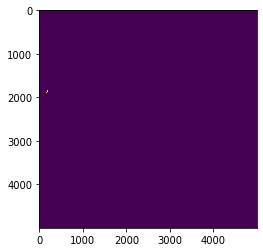

In [29]:
plt.imshow(masks[0][2]);

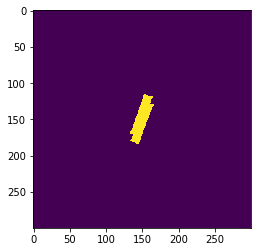

In [30]:
plt.imshow(cropped_masks[0][2]);

In [32]:
array = np.asarray(cropped_masks)
array.shape

(20,)

* 1 mask for 1 image

We can also build a unique mask (i.e. with multiple polygons) for each of the original images, by adding up (i.e. merging) the masks corresponding to each image.

In [84]:
masks=[]
for image in filenames:
    
    # Extract pixel coordinates of polygons
    polygons = labels[labels['image_name'] == image[-15:-4]]
    polygons['pixel_polygons'] = polygons.polygon_vertices_pixels.apply(lambda x: literal_eval(x))
    
    pixel_coord = []
    for sub_list in list(polygons.pixel_polygons):
        new_sub_list = [item for tuples in sub_list for item in tuples]
        pixel_coord.append(new_sub_list)
    
    counter = len(pixel_coord)
    
    # Create mask
    width=5000
    height=5000
    mask = np.zeros((5000,5000))
    for i in range(len(pixel_coord)):
            img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
            ImageDraw.Draw(img).polygon(pixel_coord[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
            mask_i = np.array(img)
            mask += mask_i
    
    # Clip overlapping polygons to binary values
    mask = np.clip(mask, 0, 1)
    masks.append(mask)

    # Write to disk
    imageio.imwrite('../Data/Duke/Modesto_masks/{}_mask.png'.format(image[-15:-4]), mask)

    print('{} polygons masked for {}'.format(counter, image[-15:]))

print('\n{} images masked in total'.format(len(masks)))

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12 polygons masked for 10sfg735670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


7 polygons masked for 10sfg735685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3 polygons masked for 10sfg750655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10 polygons masked for 10sfg750670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


60 polygons masked for 10sfg750685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0 polygons masked for 10sfg765655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


18 polygons masked for 10sfg765670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


41 polygons masked for 10sfg765685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1 polygons masked for 10sfg780655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


29 polygons masked for 10sfg780670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


40 polygons masked for 10sfg780685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14 polygons masked for 10sfg795655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


35 polygons masked for 10sfg795670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


74 polygons masked for 10sfg795685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0 polygons masked for 10sfg810655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


15 polygons masked for 10sfg810670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


156 polygons masked for 10sfg810685.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


20 polygons masked for 10sfg825655.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10 polygons masked for 10sfg825670.tif


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


37 polygons masked for 10sfg825685.tif

20 images masked in total


In [10]:
masks[0].shape

(5000, 5000)

In [11]:
print(masks[1].max())
print(masks[4].max())
print(masks[13].max())
print(masks[17].max())

1.0
1.0
1.0
1.0


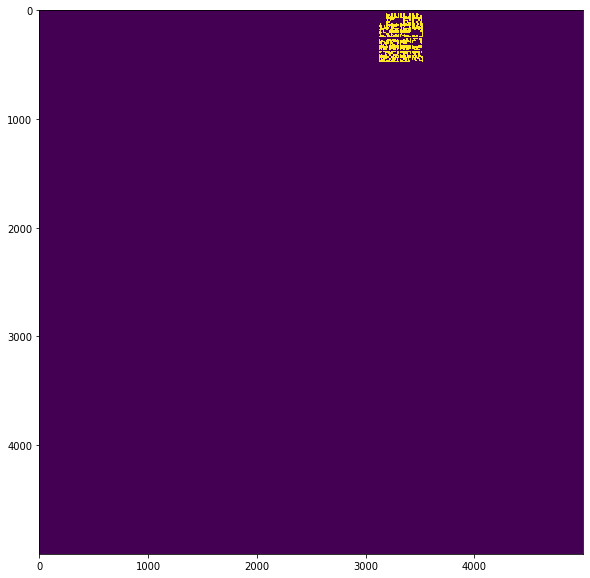

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(masks[17]);

### Final workflow

Below are the scripts to build our training dataset and masks with more efficient methods, in particular using the `image_slicer` library, built on `PIL`.

#### Modesto

* Load labels for the city of Modesto

In [8]:
labels = gpd.read_file("../Data/Duke/3385780_polygons/SolarArrayPolygons.geojson")
labels = labels[labels['city']=='Modesto']
print('There are {} PV polygons for Modesto'.format(labels.shape[0]))
labels.head(1)

There are 582 PV polygons for Modesto


,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
14710,14804,37.646419,-121.001768,120.907616,4292.078275,Modesto,30.191414,335.460156,10sfg750670,37.646992,-121.016347,37.633194,-120.999714,NAD83,10,0.3,0.903454,"[ [ 4306.3662979999999, 119.6673471 ], [ 4307....","POLYGON ((-121.00172 37.64642, -121.00172 37.6..."


* Crop images

In [41]:
filenames = glob.glob('../Data/Duke/3385789_Modesto/*.tif') # list image names
filenames.sort()

for image in filenames:
    tiles = image_slicer.slice(image, 100, save=False)
    image_slicer.save_tiles(tiles, directory='../Data/Duke/Modesto_cropped/',
                            prefix=image[-15:-4], format='png')

* Create masks (1 polygon per mask / based on original images)

In [44]:
filenames = os.listdir(path)
nb_images = len(filenames)

for index, image in enumerate(filenames):
    
    # Extract pixel coordinates of polygons
    polygons = labels[labels['image_name'] == image[:-4]]
    polygons['pixel_polygons'] = polygons.polygon_vertices_pixels.apply(lambda x: literal_eval(x))
    
    pixel_coord = []
    for sub_list in list(polygons.pixel_polygons):
        new_sub_list = [item for tuples in sub_list for item in tuples]
        pixel_coord.append(new_sub_list)
    
    counter = len(pixel_coord)
    
    # Create mask
    width=5000
    height=5000
    for i in range(len(pixel_coord)):
        img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
        ImageDraw.Draw(img).polygon(pixel_coord[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        mask_i = np.array(img)
        mask = np.zeros((5000,5000))
        mask += mask_i
        mask = img_as_ubyte(mask)

        # Write to disk
        imageio.imwrite('../Data/Duke/Modesto_masks/{}_{}.png'.format(i, image[:-4]), mask)    

    # Clip overlapping polygons to binary values
    #mask = np.clip(mask, 0, 1)
    #masks.append(mask)

    print('{}/{} - {} polygon masks created for {}'.format(index, nb_images, counter, image))
    total += counter

print('\n{} masks written in total'.format(total))

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1 polygon masks created for 10sfg780655.tif
35 polygon masks created for 10sfg795670.tif
10 polygon masks created for 10sfg750670.tif
40 polygon masks created for 10sfg780685.tif
15 polygon masks created for 10sfg810670.tif
41 polygon masks created for 10sfg765685.tif
37 polygon masks created for 10sfg825685.tif
20 polygon masks created for 10sfg825655.tif
12 polygon masks created for 10sfg735670.tif
18 polygon masks created for 10sfg765670.tif
10 polygon masks created for 10sfg825670.tif
7 polygon masks created for 10sfg735685.tif
3 polygon masks created for 10sfg750655.tif
14 polygon masks created for 10sfg795655.tif
60 polygon masks created for 10sfg750685.tif
156 polygon masks created for 10sfg810685.tif
29 polygon masks created for 10sfg780670.tif
74 polygon masks created for 10sfg795685.tif

582 masks written in total


Here, we used `PIL` (`Image` and `ImageDraw` modules) and `imageio` (`imwrite` function) to create the masks. We could also use `skimage`, with the method: `skimage.draw.polygon2mask(image_shape, polygon)` (see more [here](https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon2mask)).

* Crop masks through all polygon mask layers and save only non-empty masks

In [74]:
path = '../Data/Duke/Modesto_masks/'
counter=0
for image in os.listdir(path):
    tiles = image_slicer.slice(path+image, 100, save=False)
    tiles2=np.asarray(tiles)
    for i in range(len(tiles2)):
        if np.asarray(tiles2[i].image).max() != 0:
            image_slicer.save_tiles(tiles[i:i+1], directory='../Githubs/Mask_RCNN/datasets/solar/Modesto/Modesto_cropped_masks/',
                                    prefix=image[:-4], format='png')
            counter += 1
print(counter,'cropped masks saved in total.')

621 cropped masks saved in total.


In [220]:
# other method: write all masks, then fill in a list of images to delete

path = '../Data/Duke/Modesto_masks_cropped_2/'
to_delete = []
for image in os.listdir(path):
    input_path = os.path.join(path, image)
    if io.imread(input_path).max() == 0 : to_delete.append(image)
        
print(len(to_delete))

os.chdir(path)
for f in to_delete:
    if os.path.isfile(f): os.remove(f)

* Compare with image chunks and delete images without solar arrays

In [40]:
path='../Githubs/Mask_RCNN/datasets/solar/Modesto/Modesto_cropped_masks/'
to_keep = os.listdir(path)
to_keep = [x[:-4] for x in to_keep]
to_keep = [x[:16] for x in to_keep]
to_keep = list(dict.fromkeys(to_keep)) # Creating a dictionary will automatically delete duplicates!
print(len(to_keep))
to_keep

219


['10sfg810685_01_02',
 '10sfg810685_03_08',
 '10sfg810685_04_02',
 '10sfg810685_02_02',
 '10sfg780685_05_08',
 '10sfg765685_05_02',
 '10sfg750685_03_05',
 '10sfg765685_03_02',
 '10sfg750685_04_04',
 '10sfg735685_03_01',
 '10sfg780685_10_05',
 '10sfg795685_02_01',
 '10sfg795685_03_01',
 '10sfg795655_09_01',
 '10sfg795655_01_07',
 '10sfg795670_09_01',
 '10sfg750685_09_01',
 '10sfg825655_01_07',
 '10sfg810685_09_10',
 '10sfg810685_04_04',
 '10sfg810685_04_09',
 '10sfg795670_08_01',
 '10sfg780685_01_02',
 '10sfg810685_04_07',
 '10sfg810685_02_01',
 '10sfg780685_03_09',
 '10sfg810685_03_07',
 '10sfg810685_03_10',
 '10sfg750685_04_05',
 '10sfg780685_08_02',
 '10sfg765670_01_04',
 '10sfg780685_10_09',
 '10sfg795685_04_10',
 '10sfg810670_01_10',
 '10sfg810685_01_10',
 '10sfg750685_02_07',
 '10sfg810685_04_06',
 '10sfg810685_04_10',
 '10sfg825655_01_08',
 '10sfg825685_01_09',
 '10sfg825685_05_01',
 '10sfg795685_03_07',
 '10sfg810670_05_09',
 '10sfg810670_02_02',
 '10sfg795685_03_02',
 '10sfg780

In [42]:
path='../Data/Duke/Modesto_cropped/'
for filename in os.listdir(path):
    if filename[:-4] not in to_keep: os.remove(path+filename)

* Rename cropped masks properly

In [76]:
path='../Githubs/Mask_RCNN/datasets/solar/Modesto/Modesto_cropped_masks/'

for counter, filename in enumerate(os.listdir(path)): 
    if len(filename) == 23:
        new_name = filename[2:-4] + '_' + filename[0] + filename[-4:]
    elif len(filename) == 24:
        new_name = filename[3:-4] + '_' + filename[0:2] + filename[-4:]
    elif len(filename) == 25:
        new_name = filename[4:-4] + '_' + filename[0:3] + filename[-4:]
    else:
        new_name = filename[5:-4] + '_' + filename[0:4] + filename[-4:]

    os.rename(os.path.join(path, filename), os.path.join(path, new_name))

print(counter, 'masks succesfully renamed.')

622 masks succesfully renamed.


* Train/test split

For the first training, using only Modesto images, I organized my dataset folder as follows:
* train: 175 images (Modesto)
* val: 44 images (20%)
* masks: the masks corresponding to each image

Here is the code I used to pick 44 random images for validation. When using the `train_test_split` argument in the `load_solar` function, split becomes automatic.

In [36]:
image_dir = '/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar/Modesto/Modesto_cropped/'
image_ids = os.listdir(image_dir)
val_ids = random.sample(image_ids, 44)
val_ids

['10sfg810670_02_04.png',
 '10sfg795685_09_02.png',
 '10sfg810670_02_02.png',
 '10sfg795670_09_06.png',
 '10sfg750685_05_06.png',
 '10sfg825685_07_03.png',
 '10sfg825670_04_05.png',
 '10sfg780685_02_08.png',
 '10sfg780685_03_10.png',
 '10sfg765685_02_02.png',
 '10sfg750685_04_04.png',
 '10sfg795685_09_01.png',
 '10sfg750670_05_04.png',
 '10sfg810670_07_06.png',
 '10sfg750685_03_04.png',
 '10sfg780685_01_02.png',
 '10sfg750655_04_04.png',
 '10sfg795685_04_10.png',
 '10sfg750685_01_09.png',
 '10sfg825685_04_01.png',
 '10sfg780670_03_07.png',
 '10sfg765685_03_04.png',
 '10sfg735670_02_06.png',
 '10sfg780670_01_02.png',
 '10sfg765670_06_01.png',
 '10sfg795685_08_07.png',
 '10sfg810685_04_04.png',
 '10sfg780685_05_08.png',
 '10sfg780685_01_01.png',
 '10sfg810685_04_02.png',
 '10sfg795655_10_05.png',
 '10sfg750670_08_05.png',
 '10sfg750685_03_09.png',
 '10sfg795685_02_06.png',
 '10sfg735670_05_05.png',
 '10sfg765670_10_09.png',
 '10sfg780685_03_03.png',
 '10sfg750685_02_09.png',
 '10sfg75068

In [37]:
val_dir = '/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar/val/'
for file in val_ids:
    shutil.move(image_dir + file, val_dir)

#### Stockton

* Load labels for the city of Stockton

In [5]:
labels = gpd.read_file("../Data/Duke/3385780_polygons/SolarArrayPolygons.geojson")
labels = labels[labels['city']=='Stockton']
print('There are {} PV polygons for Stockton'.format(labels.shape[0]))
labels.head(1)

There are 2546 PV polygons for Stockton


,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
16887,17182,38.061624,-121.257564,3047.873352,1196.21836,Stockton,26.385566,293.172955,10sfh525135,38.069922,-121.261458,38.056156,-121.244686,NAD83,10,0.3,0.885137,"[ [ 1202.963254, 3060.528523 ], [ 1203.776805,...","POLYGON ((-121.25754 38.06159, -121.25754 38.0..."


In [39]:
# Write geojson for Stockton labels
labels.to_file("../Githubs/Mask_RCNN/datasets/solar/polygons/Stockton_polygons.geojson", driver="GeoJSON")

* Crop images

In [4]:
filenames = glob.glob('../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_images/*.tif') # list image names
filenames.sort()
filenames[0][-15:-4]

'10sfg465970'

In [6]:
for image in filenames:
    tiles = image_slicer.slice(image, 100, save=False)
    image_slicer.save_tiles(tiles, directory='../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_cropped_images/',
                            prefix=image[-15:-4], format='png')

* Create masks (1 polygon per mask / based on original images)

In [7]:
total = 0
path = '../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_images/'
filenames = os.listdir(path)
nb_images = len(filenames)

for index, image in enumerate(filenames):
    
    # Extract pixel coordinates of polygons
    polygons = labels[labels['image_name'] == image[:-4]]
    polygons['pixel_polygons'] = polygons.polygon_vertices_pixels.apply(lambda x: literal_eval(x))
    
    pixel_coord = []
    for sub_list in list(polygons.pixel_polygons):
        new_sub_list = [item for tuples in sub_list for item in tuples]
        pixel_coord.append(new_sub_list)
    
    counter = len(pixel_coord)
    
    # Create mask
    width=5000
    height=5000
    for i in range(len(pixel_coord)):
        img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
        ImageDraw.Draw(img).polygon(pixel_coord[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        mask_i = np.array(img)
        mask = np.zeros((5000,5000))
        mask += mask_i
        mask = img_as_ubyte(mask)

        # Write to disk
        imageio.imwrite('../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_masks/{}_{}.png'.format(i, image[:-4]), mask)    

    # Clip overlapping polygons to binary values
    #mask = np.clip(mask, 0, 1)
    #masks.append(mask)

    print('{}/{} - {} polygon masks created for {}'.format(index+1, nb_images, counter, image))
    total += counter

print('\n{} masks written in total'.format(total))

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


7 polygon masks created for 10sfg540970.tif
66 polygon masks created for 10sfh450060.tif
49 polygon masks created for 10sfh465030.tif
9 polygon masks created for 10sfh510120.tif
0 polygon masks created for 10sfg510955.tif
13 polygon masks created for 10sfh510135.tif
91 polygon masks created for 10sfh450075.tif
25 polygon masks created for 10sfh495075.tif
0 polygon masks created for 10sfh480120.tif
32 polygon masks created for 10sfg480955.tif
5 polygon masks created for 10sfg555985.tif
46 polygon masks created for 10sfh495060.tif
22 polygon masks created for 10sfh480045.tif
0 polygon masks created for .DS_Store
4 polygon masks created for 10sfg510985.tif
4 polygon masks created for 10sfg495970.tif
7 polygon masks created for 10sfh495105.tif
42 polygon masks created for 10sfh510090.tif
8 polygon masks created for 10sfh510045.tif
3 polygon masks created for 10sfh525015.tif
111 polygon masks created for 10sfh450105.tif
12 polygon masks created for 10sfh540060.tif
13 polygon masks created f

Here, we used `PIL` (`Image` and `ImageDraw` modules) and `imageio` (`imwrite` function) to create the masks. We could also use `skimage`, with the method: `skimage.draw.polygon2mask(image_shape, polygon)` (see more [here](https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon2mask)).

* Crop masks through all polygon mask layers and save only non-empty masks

In [8]:
path = '../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_masks/'
counter=0
for image in os.listdir(path):
    tiles = image_slicer.slice(path+image, 100, save=False)
    tiles2=np.asarray(tiles)
    for i in range(len(tiles2)):
        if np.asarray(tiles2[i].image).max() != 0:
            image_slicer.save_tiles(tiles[i:i+1], directory='../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_cropped_masks/',
                                    prefix=image[:-4], format='png')
            counter += 1
print(counter,'cropped masks saved in total.')

2790 cropped masks saved in total.


* Compare with image chunks and delete images without solar arrays

In [26]:
path='../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_cropped_masks/'
to_keep = os.listdir(path)
to_keep = [x[:-4] for x in to_keep]
to_keep = [x[-17:] for x in to_keep]
to_keep = list(dict.fromkeys(to_keep)) # Creating a dictionary will automatically delete duplicates!
print(len(to_keep))
to_keep

1204


['10sfh510105_05_08',
 '10sfh465060_09_02',
 '10sfh450105_02_06',
 '10sfh435120_06_07',
 '10sfh450105_04_10',
 '10sfh480090_10_05',
 '10sfh450120_10_03',
 '10sfh435120_06_04',
 '10sfh525105_07_06',
 '10sfh450060_04_08',
 '10sfh480105_08_01',
 '10sfg480970_07_05',
 '10sfh450075_07_09',
 '10sfh465075_03_05',
 '10sfh420105_04_08',
 '10sfh420105_06_08',
 '10sfh495045_07_08',
 '10sfh420105_05_07',
 '10sfh450090_10_02',
 '10sfh480060_07_06',
 '10sfh435120_07_08',
 '10sfh450045_10_09',
 '10sfh465105_09_08',
 '10sfh510105_02_06',
 '10sfh525090_01_01',
 '10sfh510135_07_03',
 '10sfh435105_09_04',
 '10sfh510045_07_06',
 '10sfh435060_04_03',
 '10sfh450120_04_04',
 '10sfh450090_06_09',
 '10sfh465120_03_08',
 '10sfh420120_05_01',
 '10sfh420120_07_08',
 '10sfh495075_02_04',
 '10sfh435060_07_05',
 '10sfh435060_02_02',
 '10sfh465120_07_03',
 '10sfh450120_09_04',
 '10sfh450075_10_02',
 '10sfh420120_02_06',
 '10sfg525955_08_07',
 '10sfh435060_09_07',
 '10sfh525090_02_07',
 '10sfh495060_04_08',
 '10sfh450

In [33]:
path = '../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_cropped_images/'
for filename in os.listdir(path):
    if filename[:-4] not in to_keep: os.remove(path+filename)

* Rename cropped masks properly

In [38]:
path='../Githubs/Mask_RCNN/datasets/other solar/Stockton/Stockton_cropped_masks/'

for counter, filename in enumerate(os.listdir(path)): 
    if len(filename) == 23:
        new_name = filename[2:-4] + '_' + filename[0] + filename[-4:]
    elif len(filename) == 24:
        new_name = filename[3:-4] + '_' + filename[0:2] + filename[-4:]
    elif len(filename) == 25:
        new_name = filename[4:-4] + '_' + filename[0:3] + filename[-4:]
    else:
        new_name = filename[5:-4] + '_' + filename[0:4] + filename[-4:]

    os.rename(os.path.join(path, filename), os.path.join(path, new_name))

print(counter+1, 'masks succesfully renamed.')

2789 masks succesfully renamed.


#### Oxnard

Careful: Oxnard images have a different size, 4000x6000 pixels, and ids of different length (9 characters).

* Load labels for the city of Oxnard

In [22]:
labels = gpd.read_file("../Githubs/Mask_RCNN/datasets/solar/polygons/Oxnard_polygons.geojson")
print('There are {} PV polygons for Oxnard'.format(labels.shape[0]))
labels.head(1)

There are 1595 PV polygons for Oxnard


,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
0,15417,34.243116,-119.160561,2118.488363,3428.374855,Oxnard,90.020804,1000.231156,621051913,34.248828,-119.171986,34.238028,-119.151981,NAD83,0405,0.3,0.0,"[ [ 3431.086221, 2143.6813189999998 ], [ 3414....","POLYGON ((-119.16055 34.24305, -119.16061 34.2..."


* Crop images

If we use the same method as for other cities, i.e. `image_slicer`, we will get 100 images of size 400x600 pixels. To choose a specific splitting size, we need to use `rasterio.window`:

In [2]:
filenames = glob.glob('../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_images/*.tif') # list image names
filenames.sort()
outfile = '../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_images/{}_{}_{}.tif' # define the path for cropped images

In [3]:
def get_tiles(ds, width=500, height=500):
    ncols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = rio.windows.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    for col_off, row_off in offsets:
        window = rio.windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = rio.windows.transform(window, ds.transform)
        yield window, transform

In [9]:
counter=0

for image in filenames[10:11]:
       
    with rio.open(image) as inds:

        meta = inds.meta.copy()
        
        for window, transform in get_tiles(inds):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outpath = outfile.format(image[-13:-4], int(window.col_off), int(window.row_off))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(inds.read(window=window))
            counter += 1

print('\n{} images written in total'.format(counter))


96 images written in total


But this doesn't give us image names in a correct format. So we will stick with the simpler `image_split` method, and set it to 144 images. We will get rectangular images of size 500x333, and we will just need to pad them with zeros as part of the Mask RCNN workflow.

In [17]:
filenames = glob.glob('../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_images/*.tif') # list image names
filenames.sort()
filenames[0][-13:-4]

'618051897'

In [19]:
n_images = len(filenames)
for index, image in enumerate(filenames):
    tiles = image_slicer.slice(image, 144, save=False)
    image_slicer.save_tiles(tiles, directory='../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_images/',
                            prefix=image[-13:-4], format='png')
    print("{}/{}".format(index+1, n_images))

0/75
1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75


* Create masks (1 polygon per mask / based on original images)

In [25]:
total = 0
path = '../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_images/'
filenames = os.listdir(path)
nb_images = len(filenames)

for index, image in enumerate(filenames):
    
    # Extract pixel coordinates of polygons
    polygons = labels[labels['image_name'] == image[:-4]]
    polygons['pixel_polygons'] = polygons.polygon_vertices_pixels.apply(lambda x: literal_eval(x))
    
    pixel_coord = []
    for sub_list in list(polygons.pixel_polygons):
        new_sub_list = [item for tuples in sub_list for item in tuples]
        pixel_coord.append(new_sub_list)
    
    counter = len(pixel_coord)
    
    # Create mask
    width=6000
    height=4000
    for i in range(len(pixel_coord)):
        img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
        ImageDraw.Draw(img).polygon(pixel_coord[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        mask_i = np.array(img)
        mask = np.zeros((4000,6000))
        mask += mask_i
        mask = img_as_ubyte(mask)

        # Write to disk
        imageio.imwrite('../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_masks/{}_{}.png'.format(i, image[:-4]), mask)    

    # Clip overlapping polygons to binary values
    #mask = np.clip(mask, 0, 1)
    #masks.append(mask)

    print('{}/{} - {} polygon masks created for {}'.format(index+1, nb_images, counter, image))
    total += counter

print('\n{} masks written in total'.format(total))

/Users/Thomas/opt/anaconda3/envs/total/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1/75 - 2 polygon masks created for 620451913.tif
2/75 - 10 polygon masks created for 619251917.tif
3/75 - 5 polygon masks created for 619251877.tif
4/75 - 0 polygon masks created for 620451873.tif
5/75 - 18 polygon masks created for 619251889.tif
6/75 - 25 polygon masks created for 619851901.tif
7/75 - 0 polygon masks created for 621651881.tif
8/75 - 0 polygon masks created for 619851877.tif
9/75 - 0 polygon masks created for 621651897.tif
10/75 - 29 polygon masks created for 619851917.tif
11/75 - 0 polygon masks created for 621651909.tif
12/75 - 4 polygon masks created for 619851889.tif
13/75 - 160 polygon masks created for 619251901.tif
14/75 - 41 polygon masks created for 620451905.tif
15/75 - 103 polygon masks created for 620451901.tif
16/75 - 7 polygon masks created for 619251905.tif
17/75 - 0 polygon masks created for 618051909.tif
18/75 - 0 polygon masks created for 619851913.tif
19/75 - 0 polygon masks created for 619851873.tif
20/75 - 0 polygon masks created for 621651893.tif


We can remark here that lots of images of Oxnard do not have solar panels!

* Crop masks through all polygon mask layers and save only non-empty masks

In [29]:
path = '../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_masks/'
filenames = os.listdir(path)
n_masks = len(filenames)
counter=0
for index, image in enumerate(filenames):
    tiles = image_slicer.slice(path+image, 144, save=False)
    tiles2=np.asarray(tiles)
    for i in range(len(tiles2)):
        if np.asarray(tiles2[i].image).max() != 0:
            image_slicer.save_tiles(tiles[i:i+1], directory='../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_masks/',
                                    prefix=image[:-4], format='png')
            counter += 1
    if (index+1)%25 == 0:
        print("{}/{}".format(index+1, n_masks)) 
print(counter,'cropped masks saved in total.')

25/1595
50/1595
75/1595
100/1595
125/1595
150/1595
175/1595
200/1595
225/1595
250/1595
275/1595
300/1595
325/1595
350/1595
375/1595
400/1595
425/1595
450/1595
475/1595
500/1595
525/1595
550/1595
575/1595
600/1595
625/1595
650/1595
675/1595
700/1595
725/1595
750/1595
775/1595
800/1595
825/1595
850/1595
875/1595
900/1595
925/1595
950/1595
975/1595
1000/1595
1025/1595
1050/1595
1075/1595
1100/1595
1125/1595
1150/1595
1175/1595
1200/1595
1225/1595
1250/1595
1275/1595
1300/1595
1325/1595
1350/1595
1375/1595
1400/1595
1425/1595
1450/1595
1475/1595
1500/1595
1525/1595
1550/1595
1575/1595
1806 cropped masks saved in total.


* Compare with image chunks and delete images without solar arrays

In [31]:
path='../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_masks/'
to_keep = os.listdir(path)
to_keep = [x[:-4] for x in to_keep]
to_keep = [x[-15:] for x in to_keep]
to_keep = list(dict.fromkeys(to_keep)) # Creating a dictionary will automatically delete duplicates!
print(len(to_keep))
to_keep

483


['621651901_09_11',
 '620451901_01_06',
 '620451897_06_03',
 '619251901_03_11',
 '621051897_07_07',
 '619251901_04_11',
 '619251893_11_07',
 '621651901_08_11',
 '621651901_08_10',
 '618651917_03_06',
 '620451897_03_05',
 '619851893_12_05',
 '620451901_01_01',
 '621051901_11_04',
 '621051893_02_05',
 '621051897_06_07',
 '620451909_01_02',
 '620451909_05_01',
 '619251901_02_11',
 '620451901_01_02',
 '618651897_12_05',
 '620451909_07_04',
 '620451909_02_11',
 '621651901_09_02',
 '619851885_08_11',
 '620451893_05_03',
 '619251881_01_06',
 '619851905_08_10',
 '620451877_05_05',
 '619851917_03_12',
 '621051897_08_07',
 '620451897_03_04',
 '621651901_07_11',
 '620451877_01_11',
 '621051901_10_04',
 '621051893_09_07',
 '621651901_11_02',
 '620451881_09_02',
 '618651893_03_05',
 '621051893_02_04',
 '619851885_12_01',
 '619251889_06_10',
 '621651901_08_02',
 '621051905_02_05',
 '619251889_08_04',
 '619851905_02_09',
 '621051909_06_11',
 '620451901_10_04',
 '621651901_10_02',
 '619851901_03_04',


In [32]:
path = '../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_images/'
for filename in os.listdir(path):
    if filename[:-4] not in to_keep: os.remove(path+filename)

* Rename cropped masks properly

In [38]:
path='../Githubs/Mask_RCNN/datasets/other solar/Oxnard/Oxnard_cropped_masks/'

for counter, filename in enumerate(os.listdir(path)): 
    if len(filename) == 21:
        new_name = filename[2:-4] + '_' + filename[0] + filename[-4:]
    elif len(filename) == 22:
        new_name = filename[3:-4] + '_' + filename[0:2] + filename[-4:]
    elif len(filename) == 23:
        new_name = filename[4:-4] + '_' + filename[0:3] + filename[-4:]
    else:
        new_name = filename[5:-4] + '_' + filename[0:4] + filename[-4:]

    os.rename(os.path.join(path, filename), os.path.join(path, new_name))

print(counter+1, 'masks succesfully renamed.')

1805 masks succesfully renamed.


## Functions for Mask R-CNN

For training, we will use the free GPU available on Google Colab. You can run the command `!nvidia-smi` in Colab to check GP specs - it's usually a NVIDIA Tesla P100 with 16Gb RAM. Training is also possible on Colab, with an NVIDIA Tesla T4 16Gb RAM, with roughly equivalent performance.

### Load images and masks from files

To adapt the Mask R-CNN `Dataset` class, which loads and prepares the dataset for training, we need:
* a `load_images` function that takes as arguments _self_ and _dataset_dir_, and adds the classes and pre-processed images to _self_ (see balloons example)
* a `load_masks` function that takes as arguments an image and returns its mask.

I used `balloons.py` and other examples to get how it works exactly, and below you will find some experiments that helped me build functions for `solar.py`.

In [21]:
dataset_dir = '/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar'
subset = 'train'
dataset_dir = os.path.join(dataset_dir, subset)

In [22]:
# All the following lines do the same, i.e. get image ids from file names in directory
image_ids = os.listdir(dataset_dir)
image_ids = next(os.walk(dataset_dir))[2]
image_ids = list(set(image_ids)) # set = unordered list, in {}
image_ids

['10sfg735670_02_05.png',
 '10sfg735670_05_08.png',
 '10sfg735670_04_01.png',
 '10sfg735670_02_06.png',
 '10sfg735670_05_05.png']

In [23]:
image_ids = [image_id[:-4] for image_id in image_ids]
image_ids

['10sfg735670_02_05',
 '10sfg735670_05_08',
 '10sfg735670_04_01',
 '10sfg735670_02_06',
 '10sfg735670_05_05']

In [24]:
os.path.join(dataset_dir, image_ids[0] + ".png")

'/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar/train/10sfg735670_02_05.png'

* Load masks (from .png files)

In [27]:
# Get mask directory from image path
mask_dir = os.path.join(os.path.dirname(os.path.dirname('/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar/train/10sfg735670_02_05.png')), "masks") # 2 levels above images
mask_dir

'/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Githubs/Mask_RCNN/datasets/solar/masks'

In [40]:
# For each image, read mask files from .png images

image_id = '10sfg735670_05_05'
mask = []
for f in next(os.walk(mask_dir))[2]:
    if f.startswith(image_id):
        m = io.imread(os.path.join(mask_dir, f)).astype(np.bool)
        mask.append(m)
mask = np.stack(mask, axis=-1)

mask.shape

(500, 500, 3)

### Add relative luminance

Relative luminance is a measure of brightness. It could be useful when trying to detect solar panels, which often reflect solar light and appear brighter than their environment in aerial images.

Relative luminance, noted Y, is computed as a weighted average of the R, G and B colour channels:

$$ Y = 0.2126R + 0.7152G + 0.0722B $$

Before training, we will compute and add the Y channel to all the images in our dataset.

In [31]:
def add_rel_lum(image_id):
    image = io.imread(image_id)
    rel_lum_layer = 0.2126*image[:,:,0] + 0.7152*image[:,:,1] + 0.0722*image[:,:,2]
    new_image = np.dstack((image, rel_lum_layer))
    return new_image

Remark: `skimage` reads images as RGB, same as `PIL`. `opencv` reads them as BGR. With `PIL`, you can check using `image.mode` (returns 'RGB').

In [23]:
image_id = '../Githubs/Mask_RCNN/datasets/solar/Modesto/Modesto_cropped/10sfg735670_02_05.png'
image = io.imread(image_id)

In [24]:
image.shape

(500, 500, 3)

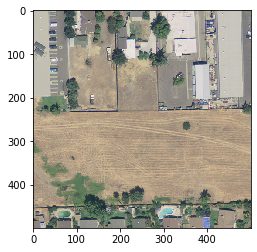

In [25]:
plt.imshow(image);

In [32]:
new_image = add_rel_lum(image_id)

In [33]:
new_image.shape

(500, 500, 4)

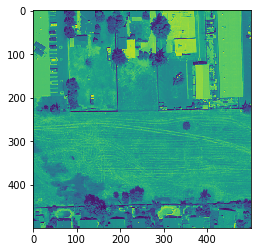

In [40]:
plt.imshow(new_image[...,3]); # doesn't show true colors